In [1]:
import json
import pandas as pd
import argparse
import os
import re
import numpy as np


In [2]:
response_file_path = 'B:/Projects/alligator/Data/exampleResponse.json'
gt_file_path = 'B:/Projects/alligator/gh/gt/cea_gt.csv'
include_nil = True
threshold = 0.2

In [3]:
gt = pd.read_csv(gt_file_path, header=None)
gt.columns = ["table_name", "row", "col", "qid"]
tables_names = gt["table_name"].unique().tolist()
url_regex = re.compile(r"http(s)?\:////www/.wikidata/.org\/(wiki|entity)\/")
gt["qid"] = gt["qid"].map(lambda x: url_regex.sub("", x))

if not include_nil:
    gt_mapping = {
        f"{row.table_name}-{row.row}-{row.col}": {"target": row.qid}
        for row in gt.itertuples()
        if row.qid.startswith("Q")
    }
    gt_mapping_nil = {
        f"{row.table_name}-{row.row}-{row.col}": {"target": row.qid}
        for row in gt.itertuples()
        if row.qid.lower() == "nil"
    }
else:
    gt_mapping = {f"{row.table_name}-{row.row}-{row.col}": {"target": row.qid} for row in gt.itertuples()}
    gt_mapping_nil = {}

tp = 0
all_gt = len(gt) - len(gt_mapping_nil)
all_predicted = 0
current_table = None
current_table_name = 'Github_Testset'
alligator_annotations = None

In [4]:
# read json file
with open(response_file_path) as f:
    alligator_annotations = json.load(f)

In [5]:
alligator_annotations = alligator_annotations["semanticAnnotations"]["cea"]

In [6]:
alligator_annotations[7]

{'idColumn': 0,
 'idRow': 133,
 'entity': [{'id': 'Q60294169',
   'name': 'ankura',
   'type': [{'id': 'Q56436498', 'name': 'village in India'}],
   'description': 'village in purulia district',
   'match': False,
   'score': 0.026,
   'features': [{'id': 'delta', 'value': 0.023},
    {'id': 'omega', 'value': 0.024},
    {'id': 'levenshtein_distance', 'value': 1.0},
    {'id': 'jaccard_distance', 'value': 1.0},
    {'id': 'popularity', 'value': 0.0}]},
  {'id': 'Q60294169',
   'name': 'ankura',
   'type': [{'id': 'Q56436498', 'name': 'village in India'}],
   'description': 'village in purulia district',
   'match': False,
   'score': 0.026,
   'features': [{'id': 'delta', 'value': 0.023},
    {'id': 'omega', 'value': 0.024},
    {'id': 'levenshtein_distance', 'value': 1.0},
    {'id': 'jaccard_distance', 'value': 1.0},
    {'id': 'popularity', 'value': 0.0}]},
  {'id': 'Q91265471',
   'name': 'ankura singh',
   'type': [{'id': 'Q5', 'name': 'human'},
    {'id': 'Q1650915', 'name': 'res

In [65]:
with open('B:/Projects/alligator/Data/organization_subclass.txt') as org_subclasses:
    org_subclasses = org_subclasses.read().splitlines()
    org_subclasses = ["Q"+ org for org in org_subclasses]

# create a mapping of the ground truth for nil and non nil values
gt_mapping = {
        f"{row.table_name}-{row.row}-{row.col}": {"target": row.qid}
        for row in gt.itertuples()
        if row.qid.startswith("Q")
}
gt_mapping_nil = {
    f"{row.table_name}-{row.row}-{row.col}": {"target": row.qid}
    for row in gt.itertuples()
    if row.qid.lower() == "nil"
}

# find how many of the first entities are organizations
org_entity_count = 0
org_entity_count_nil = 0
org_entity_count_nonnil = 0
denom = len(alligator_annotations)
denom_nil = len(gt_mapping_nil)
denom_nonnil = len(gt_mapping)

for i in alligator_annotations:
    key = "{}-{}-{}".format(current_table_name, i["idRow"], i["idColumn"])

    # reduce the number of rows that have no entities from denominator
    if len(i["entity"]) == 0:
        denom -= 1
        if key in gt_mapping_nil:
            denom_nil -= 1
        elif key in gt_mapping:
            denom_nonnil -= 1
        else:
            raise Exception("This should not happen.")
        continue


    entity_types = [type["id"] for type in i["entity"][0]["type"]]

    type_intersect = set(entity_types).intersection(org_subclasses)
    if type_intersect:
        org_entity_count += 1
        if key in gt_mapping_nil:
            org_entity_count_nil += 1
        elif key in gt_mapping:
            org_entity_count_nonnil += 1
        else:
            raise Exception("This should not happen.")

print(f"From {denom} rows that have entities, {denom - org_entity_count} first ranked candidates are not subclasses of organizations which is {100 - org_entity_count/denom*100:.2f}% percent of the total.")
print(f"From {denom_nil} rows that have nil as ground truth, {denom_nil - org_entity_count_nil} first ranked candidates are not subclasses of organizations which is {100 - org_entity_count_nil/denom_nil*100:.2f}% percent. This is {(denom_nil - org_entity_count_nil)/denom*100:.2f}% of the total.")
print(f"From {denom_nonnil} rows that have non-nil as ground truth, {denom_nonnil - org_entity_count_nonnil} first ranked candidates are not subclasses of organizations which is {100 - org_entity_count_nonnil/denom_nonnil*100:.2f}% percent. This is {(denom_nonnil - org_entity_count_nonnil)/denom*100:.2f}% of the total.")

From 426 rows that have entities, 169 first ranked candidates are not subclasses of organizations which is 39.67% percent of the total.
From 153 rows that have nil as ground truth, 104 first ranked candidates are not subclasses of organizations which is 67.97% percent. This is 24.41% of the total.
From 273 rows that have non-nil as ground truth, 65 first ranked candidates are not subclasses of organizations which is 23.81% percent. This is 15.26% of the total.


In [53]:
set([10,20]) & set([1,2,3])

set()

In [6]:
performance_metrics = []

for threshold in np.arange(0.0, 1.0, 0.01):
    tp = 0
    all_gt = len(gt) - len(gt_mapping_nil)
    all_predicted = 0

    for annotation in alligator_annotations:
        key = "{}-{}-{}".format(current_table_name, annotation["idRow"], annotation["idColumn"])
        # if key in gt_mapping_nil:
        #     continue
        if key not in gt_mapping:
            continue
        predicted_qid = ""
        if len(annotation["entity"]) > 0:
            if annotation["entity"][0]["score"] >= threshold:
                all_predicted += 1
                predicted_qid = annotation["entity"][0]["id"]
        if predicted_qid != "" and predicted_qid in gt_mapping[key]["target"]:
            tp += 1

    precision = tp / all_predicted if all_predicted > 0 else 0
    recall = tp / all_gt if all_gt > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    performance_metrics.append([threshold, precision, recall, f1])

    print("Number of mentions to be linked:", all_gt)
    print("Number of mentions linked:", all_predicted)
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1: {:.4f}".format(f1))
    print("Threshold: ", threshold)
    print("=====================================")

Number of mentions to be linked: 494
Number of mentions linked: 426
Precision: 0.3991
Recall: 0.3441
F1: 0.3696
Threshold:  0.0
Number of mentions to be linked: 494
Number of mentions linked: 382
Precision: 0.3901
Recall: 0.3016
F1: 0.3402
Threshold:  0.01
Number of mentions to be linked: 494
Number of mentions linked: 310
Precision: 0.4355
Recall: 0.2733
F1: 0.3358
Threshold:  0.02
Number of mentions to be linked: 494
Number of mentions linked: 249
Precision: 0.4980
Recall: 0.2510
F1: 0.3338
Threshold:  0.03
Number of mentions to be linked: 494
Number of mentions linked: 208
Precision: 0.5337
Recall: 0.2247
F1: 0.3162
Threshold:  0.04
Number of mentions to be linked: 494
Number of mentions linked: 174
Precision: 0.5862
Recall: 0.2065
F1: 0.3054
Threshold:  0.05
Number of mentions to be linked: 494
Number of mentions linked: 158
Precision: 0.6329
Recall: 0.2024
F1: 0.3067
Threshold:  0.06
Number of mentions to be linked: 494
Number of mentions linked: 148
Precision: 0.6554
Recall: 0.19

In [7]:
performance_metrics_df = pd.DataFrame(performance_metrics, columns=["threshold", "precision", "recall", "f1"])

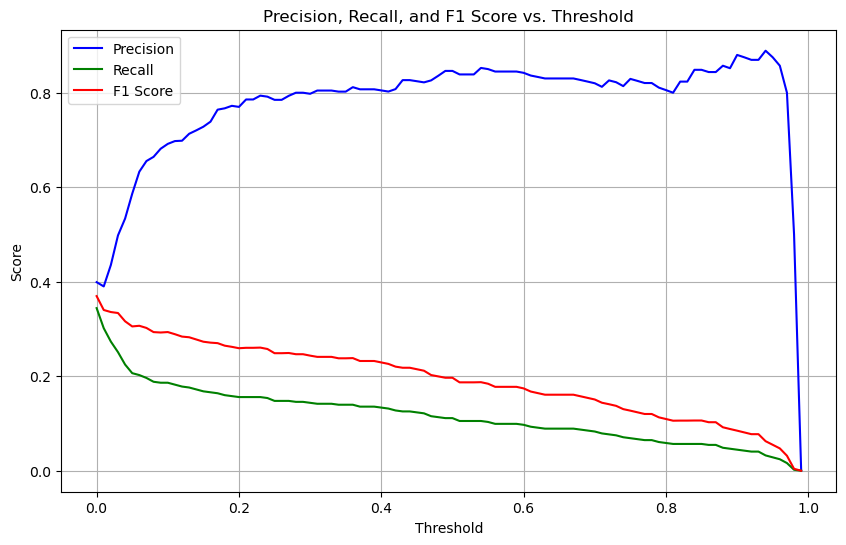

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
thresholds = performance_metrics_df["threshold"]
precision = performance_metrics_df['precision']
recall = performance_metrics_df['recall']
f1_score = performance_metrics_df['f1']

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(thresholds, precision, label='Precision', color='blue')
plt.plot(thresholds, recall, label='Recall', color='green')
plt.plot(thresholds, f1_score, label='F1 Score', color='red')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# for annotation in alligator_annotations:
#     key = "{}-{}-{}".format(current_table_name, annotation["idRow"], annotation["idColumn"])
#     # if key in gt_mapping_nil:
#     #     continue
#     if key not in gt_mapping:
#         continue
#     predicted_qid = ""
#     if len(annotation["entity"]) > 0:
#         if annotation["entity"][0]["score"] > threshold:
#             all_predicted += 1
#             predicted_qid = annotation["entity"][0]["id"]
#     if predicted_qid != "" and predicted_qid in gt_mapping[key]["target"]:
#         tp += 1

In [10]:
# precision = tp / all_predicted
# recall = tp / all_gt
# f1 = 2 * (precision * recall) / (precision + recall)
# print("Number of mentions to be linked:", all_gt)
# print("Number of mentions linked:", all_predicted)
# print("Precision: {:.4f}".format(precision))
# print("Recall: {:.4f}".format(recall))
# print("F1: {:.4f}".format(f1))

## Extract Score Ditribution for NIL Entities

In [11]:
gt_mapping = {
        f"{row.table_name}-{row.row}-{row.col}": {"target": row.qid}
        for row in gt.itertuples()
        if row.qid.startswith("Q")
    }
gt_mapping_nil = {
    f"{row.table_name}-{row.row}-{row.col}": {"target": row.qid}
    for row in gt.itertuples()
    if row.qid.lower() == "nil"
}

In [12]:
NIL_entity_Scores = []

# extract top score for each mention
for mention in alligator_annotations:
    key = "{}-{}-{}".format(current_table_name, mention["idRow"], mention["idColumn"])
    if key in gt_mapping_nil:
        NIL_entity_Scores.append(mention["entity"][0]["score"] if len(mention["entity"]) else 0)

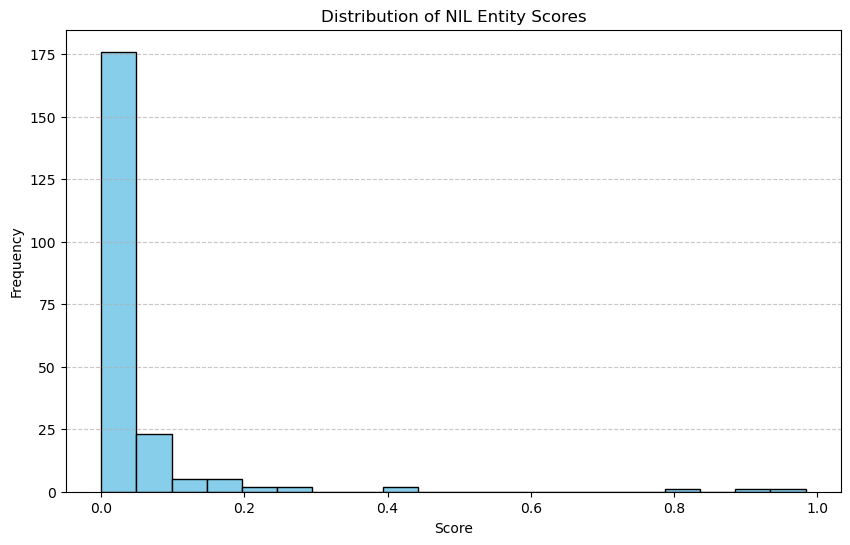

In [13]:
# Plotting the histogram for the 'Score' column
plt.figure(figsize=(10, 6))
plt.hist(NIL_entity_Scores, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of NIL Entity Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Not Nil Entities Score Dist

In [14]:
NonNil_entity_Scores = []

# extract top score for each mention
for mention in alligator_annotations:
    predicted_qid = ""
    key = "{}-{}-{}".format(current_table_name, mention["idRow"], mention["idColumn"])

    if key in gt_mapping:
        if len(mention["entity"]) > 0:
            NonNil_entity_Scores.append(mention["entity"][0]["score"])
        else:
            NonNil_entity_Scores.append(0)

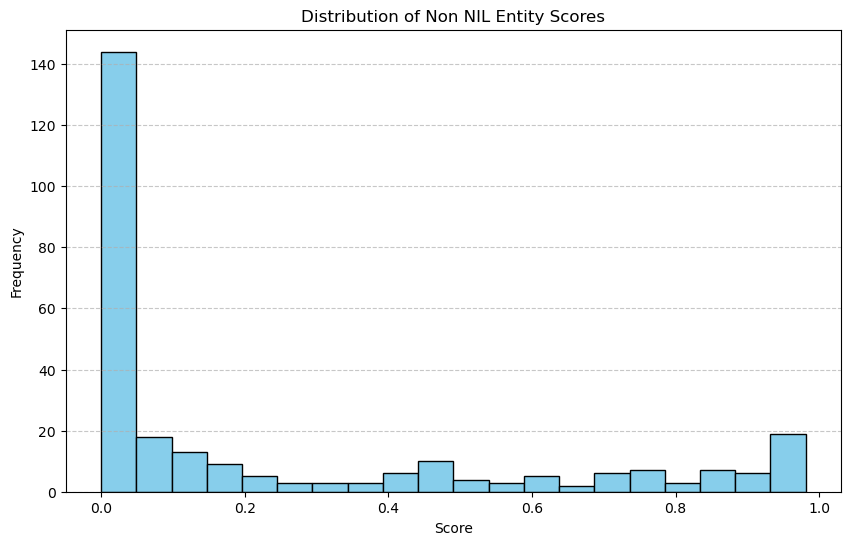

In [15]:
# Plotting the histogram for the 'Score' column
plt.figure(figsize=(10, 6))
plt.hist(NonNil_entity_Scores, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Non NIL Entity Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Create mismatched list

In [16]:
non_NIL_mismatched = []

# extract top score for each mention
for mention in alligator_annotations:
    predicted_qid = ""
    key = "{}-{}-{}".format(current_table_name, mention["idRow"], mention["idColumn"])

    if key in gt_mapping:
        temp_dic = {"key": key, "QID": gt_mapping[key]["target"]}
    else:
        continue

    if len(mention["entity"]) > 0:
        # if mention["entity"][0]["id"] == gt_mapping[key]["target"]:
        #     continue
        temp_dic["name"] = mention["entity"][0]["name"]
        temp_dic["predicted_id"] = mention["entity"][0]["id"]
        temp_dic["description"] = mention["entity"][0]["description"]
    else:
        temp_dic["name"] = ""
        temp_dic["predicted_id"] = ""
        temp_dic["description"] = ""

    non_NIL_mismatched.append(temp_dic)

predictions = pd.DataFrame(non_NIL_mismatched)
predictions.head(10)

,key,QID,name,predicted_id,description
0,Github_Testset-226-0,Q1049470,university of waterloo,Q1049470,"public research university in waterloo, ontari..."
1,Github_Testset-227-0,Q105006683,code for africa,Q117184139,data journalism nonprofit
2,Github_Testset-228-0,Q10541776,hanoi,Q1858,capital of vietnam
3,Github_Testset-229-0,Q106548172,tribunal de contas do estado do ceará,Q10384658,academic publisher
4,Github_Testset-230-0,Q107339059,zelda universe,Q107339059,the legend of zelda website
5,Github_Testset-231-0,Q107518033,baai,Q107518033,artificial intelligence research organization ...
6,Github_Testset-232-0,Q107639776,"alation, inc.",Q107639776,american software company
7,Github_Testset-233-0,Q109351566,horizon robotics,Q109351566,none
8,Github_Testset-234-0,Q109450250,chrono24,Q109450250,none
9,Github_Testset-235-0,Q1108172,coles,Q5355257,former south australian state electoral distri...


In [17]:
test_set = pd.read_csv("B:/Projects/alligator/gh/tables/Github_Testset.csv")
test_set.head()

,idd,id,company
0,29650,448931229,9 IA
1,242039,315183082,AI Data Engineer
2,79173,100204956,Department of Social Services
3,462628,33951258,Designer
4,60466,41963025,Untitled Factory


In [18]:
# change the index to key
test_set["key"] = test_set.apply(lambda x: "{}-{}-{}".format(current_table_name, x.name+1, 0), axis=1)
test_set.head()

,idd,id,company,key
0,29650,448931229,9 IA,Github_Testset-1-0
1,242039,315183082,AI Data Engineer,Github_Testset-2-0
2,79173,100204956,Department of Social Services,Github_Testset-3-0
3,462628,33951258,Designer,Github_Testset-4-0
4,60466,41963025,Untitled Factory,Github_Testset-5-0


In [19]:
# left join predictions with test_set
predictions = pd.merge(predictions, test_set, on='key', how='left')


In [20]:
predictions.head(2)

,key,QID,name,predicted_id,description,idd,id,company
0,Github_Testset-226-0,Q1049470,university of waterloo,Q1049470,"public research university in waterloo, ontari...",49293,262547236,University off Waterloo
1,Github_Testset-227-0,Q105006683,code for africa,Q117184139,data journalism nonprofit,60132,320995197,Code for Africa


## 

In [21]:
# predictions[["key", "QID", "predicted_id", "company", "name", "description", "idd"]].to_csv("B:/Projects/alligator/scripts/predictions.csv", index=False)


In [22]:
a = predictions[["key", "QID", "predicted_id", "company", "name", "description", "idd"]]
print(a[a["QID"] != a["predicted_id"]].tail(100).to_string())
# a[a["QID"] != a["predicted_id"]].to_csv("B:/Projects/alligator/Results/predictions_nonmatch.csv", index=False)

                      key         QID predicted_id                                                           company                                                name                                                                      description     idd
24   Github_Testset-250-0  Q124538126                                                                        lifebit                                                                                                                                       137013
25   Github_Testset-219-0  Q101002044     Q4697363  faculty of computer and information science ain shams university           faculty of pharmacy, ain shams university                                       faculty at the ain shams university, cairo   38055
26   Github_Testset-220-0  Q101014560     Q1230739                                  University of Texas at Arlington                    university of texas at arlington                      public research university located i